In [1]:
import requests
import numpy as np
import pandas as pd
import geopandas as gp
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
import seaborn as sns
from functools import reduce

plt.rcParams['font.size'] = 18

In [2]:
api_key = '210BA222-FC6E-3FB2-B4D7-DA2DAA1CC829'

In [3]:
state_alphas = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
                "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
                "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
                "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
                "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [2]:
# df1 = pd.read_csv('../data/historical/yields/maize_all.csv')
# df2 = pd.read_csv('../data/historical/predictors/Livneh/Livneh_maize_intra_predictors.csv')
# df3 = pd.read_csv('../data/historical/predictors/Livneh/Livneh_covariates_all.csv')

In [12]:
# df = pd.merge(df1, df2, on =['fips','year'], how='inner')
# df = pd.merge(df, df3[['maize_irr_frac', 'fips']], on = ['fips'], how = 'outer').dropna()

In [17]:
# df = df.drop(columns=['short_desc_y', 'short_desc_a'])

In [24]:
# df.to_csv('../../US_MaizeYield+Predictors_1950-2013.csv', index=False)

# Historical Crop Prices

In [60]:
prices_retain = ['date', 'value', 'short_desc']

def tidy_prices(data):
    data = data.json()
    data = pd.DataFrame(data['data'])
    data = data.query('reference_period_desc == "MARKETING YEAR"')
    data['date'] = data['year'].astype(str) + '/12/31'
    data['date'] = pd.to_datetime(data['date'])
    data['value'] = data['Value'].apply(lambda x: float(x))
    return data[prices_retain]

In [78]:
# For unit conversions: https://www.ers.usda.gov/webdocs/publications/41880/33132_ah697_002.pdf

############## Corn ##############
corn_price = requests.get('http://quickstats.nass.usda.gov/api/api_GET/?key=' + api_key + '&source_desc=SURVEY&sector_desc=CROPS&group_desc=FIELD CROPS&commodity_desc=' + 'CORN' + 
                            '&statisticcat_desc=PRICE RECEIVED&unit_desc=$ / BU&agg_level_desc=NATIONAL')
corn_price = tidy_prices(corn_price)

############## Soy ##############
soy_price = requests.get('http://quickstats.nass.usda.gov/api/api_GET/?key=' + api_key + '&source_desc=SURVEY&sector_desc=CROPS&group_desc=FIELD CROPS&commodity_desc=' + 'SOYBEANS' + 
                            '&statisticcat_desc=PRICE RECEIVED&unit_desc=$ / BU&agg_level_desc=NATIONAL')
soy_price = tidy_prices(soy_price)

############## Wheat ##############
wheat_price = requests.get('http://quickstats.nass.usda.gov/api/api_GET/?key=' + api_key + '&source_desc=SURVEY&sector_desc=CROPS&group_desc=FIELD CROPS&commodity_desc=' + 'WHEAT' + 
                            '&statisticcat_desc=PRICE RECEIVED&unit_desc=$ / BU&agg_level_desc=NATIONAL')
wheat_price = tidy_prices(wheat_price)
wheat_price = wheat_price.query('short_desc == "WHEAT - PRICE RECEIVED, MEASURED IN $ / BU"')

############## Rice ##############
rice_price = requests.get('http://quickstats.nass.usda.gov/api/api_GET/?key=' + api_key + '&source_desc=SURVEY&sector_desc=CROPS&group_desc=FIELD CROPS&commodity_desc=' + 'RICE' + 
                            '&statisticcat_desc=PRICE RECEIVED&unit_desc=$ / CWT&agg_level_desc=NATIONAL')
rice_price = tidy_prices(rice_price)
rice_price = rice_price.query('short_desc == "RICE - PRICE RECEIVED, MEASURED IN $ / CWT"')
rice_price['value'] = rice_price['value'] / 2.22 # $/cwt -> $/bu

############## Sorghum ##############
sorghum_price = requests.get('http://quickstats.nass.usda.gov/api/api_GET/?key=' + api_key + '&source_desc=SURVEY&sector_desc=CROPS&group_desc=FIELD CROPS&commodity_desc=' + 'SORGHUM' + 
                            '&statisticcat_desc=PRICE RECEIVED&unit_desc=$ / CWT&agg_level_desc=NATIONAL')
sorghum_price = tidy_prices(sorghum_price)
sorghum_price['value'] = sorghum_price['value'] / 1.78 # $/cwt -> $/bu

############## Barley ##############
barley_price = requests.get('http://quickstats.nass.usda.gov/api/api_GET/?key=' + api_key + '&source_desc=SURVEY&sector_desc=CROPS&group_desc=FIELD CROPS&commodity_desc=' + 'BARLEY' + 
                            '&statisticcat_desc=PRICE RECEIVED&unit_desc=$ / BU&agg_level_desc=NATIONAL')
barley_price = tidy_prices(barley_price)
barley_price = barley_price.query('short_desc == "BARLEY - PRICE RECEIVED, MEASURED IN $ / BU"')

############## Cotton ##############
cotton_price = requests.get('http://quickstats.nass.usda.gov/api/api_GET/?key=' + api_key + '&source_desc=SURVEY&sector_desc=CROPS&group_desc=FIELD CROPS&commodity_desc=' + 'COTTON' + 
                            '&statisticcat_desc=PRICE RECEIVED&unit_desc=$ / LB&agg_level_desc=NATIONAL')
cotton_price = tidy_prices(cotton_price)
cotton_price = cotton_price.query('short_desc == "COTTON, UPLAND - PRICE RECEIVED, MEASURED IN $ / LB"')
cotton_price['value'] = cotton_price['value'] * 32. # $/lb -> $/bu

In [86]:
################### Producer Price Index by Commodity: Farm Products ###################
##### Index 1982=100,
##### Not Seasonally Adjusted 
##### https://fred.stlouisfed.org/series/WPU01
##############################
ppi = pd.read_csv('../data/raw/WPU01.csv')
ppi['date'] = pd.to_datetime(ppi['DATE'])
# For annual prices
ppi_annual = ppi.set_index('date').resample('1Y').mean()

In [115]:
# Merge all and ajust for inflation (set to 2018 USD)
soy_ppi = pd.merge(soy_price, ppi_annual.reset_index(), on='date', how='inner')
soy_ppi['value_ppi'] = soy_ppi['value'] / soy_ppi['WPU01'] * ppi_annual.loc['2018-12-31']['WPU01']

corn_ppi = pd.merge(corn_price, ppi_annual.reset_index(), on='date', how='inner')
corn_ppi['value_ppi'] = corn_ppi['value'] / corn_ppi['WPU01'] * ppi_annual.loc['2018-12-31']['WPU01']

wheat_ppi = pd.merge(wheat_price, ppi_annual.reset_index(), on='date', how='inner')
wheat_ppi['value_ppi'] = wheat_ppi['value'] / wheat_ppi['WPU01'] * ppi_annual.loc['2018-12-31']['WPU01']

rice_ppi = pd.merge(rice_price, ppi_annual.reset_index(), on='date', how='inner')
rice_ppi['value_ppi'] = rice_ppi['value'] / rice_ppi['WPU01'] * ppi_annual.loc['2018-12-31']['WPU01']

barley_ppi = pd.merge(barley_price, ppi_annual.reset_index(), on='date', how='inner')
barley_ppi['value_ppi'] = barley_ppi['value'] / barley_ppi['WPU01'] * ppi_annual.loc['2018-12-31']['WPU01']

cotton_ppi = pd.merge(cotton_price, ppi_annual.reset_index(), on='date', how='inner')
cotton_ppi['value_ppi'] = cotton_ppi['value'] / cotton_ppi['WPU01'] * ppi_annual.loc['2018-12-31']['WPU01']

sorghum_ppi = pd.merge(sorghum_price, ppi_annual.reset_index(), on='date', how='inner')
sorghum_ppi['value_ppi'] = sorghum_ppi['value'] / sorghum_ppi['WPU01'] * ppi_annual.loc['2018-12-31']['WPU01']

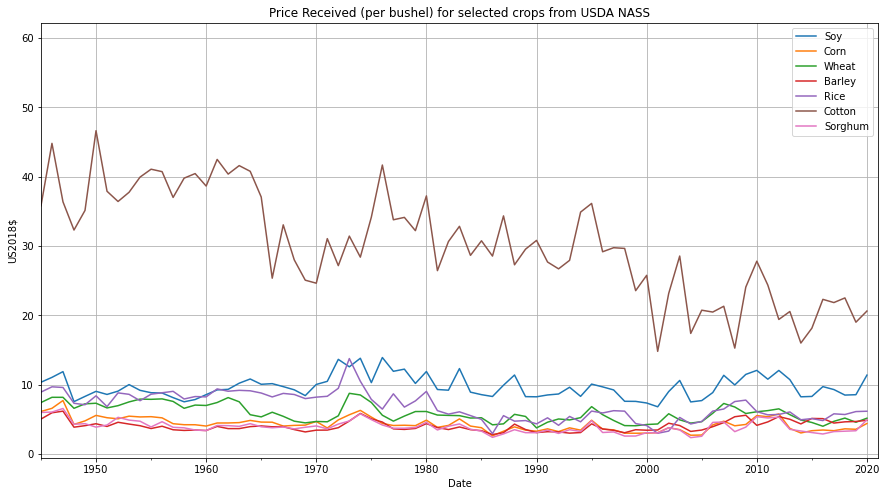

In [124]:
# Plot
fig, ax = plt.subplots(figsize=(15,8))

soy_ppi.plot(x='date', y='value_ppi', ax=ax, label="Soy")
corn_ppi.plot(x='date', y='value_ppi', ax=ax, label = 'Corn')
wheat_ppi.plot(x='date', y='value_ppi', ax=ax, label = 'Wheat')
barley_ppi.plot(x='date', y='value_ppi', ax=ax, label = 'Barley')
rice_ppi.plot(x='date', y='value_ppi', ax=ax, label = 'Rice')
cotton_ppi.plot(x='date', y='value_ppi', ax=ax, label = 'Cotton')
sorghum_ppi.plot(x='date', y='value_ppi', ax=ax, label = 'Sorghum')

ax.set_ylabel('US2018$')
ax.set_xlabel('Date')
ax.legend(loc='upper right')
ax.grid()
ax.set_title('Price Received (per bushel) for selected crops from USDA NASS')
ax.set_xlim(['1945-01-01', '2021-06-23'])
# ax.set_ylim([0,30])

plt.show()

In [127]:
# Store
soy_ppi.to_csv('../data/processed/prices/soy_ppi.csv', index=False)
corn_ppi.to_csv('../data/processed/prices/maize_ppi.csv', index=False)
wheat_ppi.to_csv('../data/processed/prices/wheat_ppi.csv', index=False)
barley_ppi.to_csv('../data/processed/prices/barley_ppi.csv', index=False)
rice_ppi.to_csv('../data/processed/prices/rice_ppi.csv', index=False)
cotton_ppi.to_csv('../data/processed/prices/cotton_ppi.csv', index=False)
sorghum_ppi.to_csv('../data/processed/prices/sorghum_ppi.csv', index=False)

# Historical yields

## Get data

In [128]:
yields_retain = ['Value', 'short_desc', 'year', 'county_code', 'state_fips_code']

def get_crop(crop_info, states):
    """
    Grabs county-level data from USDA API.
    Input: crop = baseline crop
           descriptors = additional information as dictionary
           states = list of U.S. state codes
    Output: pandas dataframe
    """
    # Build API request
    request = 'http://quickstats.nass.usda.gov/api/api_GET/?key=' + api_key + '&source_desc=SURVEY&sector_desc=CROPS&group_desc=FIELD CROPS&agg_level_desc=COUNTY&year__GE=1950'
    for key in crop_info:
        request += key + '=' + crop_info[key]
    
    # Dataframe for results
    data = pd.DataFrame()
    # Loop through states and grab
    for state in states:
        dat = requests.get(request + '&state_alpha=' + state)
        if dat.status_code == 200:
            dat = dat.json()
            dat = pd.DataFrame(dat["data"])
            data = pd.concat([data, dat], ignore_index=True)

    return data[yields_retain]

In [248]:
# NOTE this will take ~40 mins
############# Corn ##############
corn_yield_request = {'&commodity_desc':'CORN', '&util_practice_desc':'GRAIN', '&statisticcat_desc':'YIELD', '&unit_desc':'BU / ACRE'}
corn_area_request = {'&commodity_desc':'CORN', '&util_practice_desc':'GRAIN', '&statisticcat_desc':'AREA HARVESTED'}
corn_yield = get_crop(corn_yield_request, state_alphas)
corn_area = get_crop(corn_area_request, state_alphas)

############## Soy ##############
soy_yield_request = {'&commodity_desc':'SOYBEANS', '&statisticcat_desc':'YIELD', '&unit_desc':'BU / ACRE'}
soy_area_request = {'&commodity_desc':'SOYBEANS', '&statisticcat_desc':'AREA HARVESTED'}
soy_yield = get_crop(soy_yield_request, state_alphas)
soy_area = get_crop(soy_area_request, state_alphas)

############## Winter Wheat ##############
winter_wheat_yield_request = {'&commodity_desc':'WHEAT', '&class_desc':'WINTER', '&statisticcat_desc':'YIELD', '&unit_desc':'BU / ACRE'}
winter_wheat_area_request = {'&commodity_desc':'WHEAT', '&class_desc':'WINTER', '&statisticcat_desc':'AREA HARVESTED'}
winter_wheat_yield = get_crop(winter_wheat_yield_request, state_alphas).query('short_desc == "WHEAT, WINTER - YIELD, MEASURED IN BU / ACRE"')
winter_wheat_area = get_crop(winter_wheat_area_request, state_alphas).query('short_desc == "WHEAT, WINTER - ACRES HARVESTED"')

############## Spring Wheat ##############
spring_wheat_yield_request = {'&commodity_desc':'WHEAT', '&class_desc':'SPRING, (EXCL DURUM)', '&statisticcat_desc':'YIELD', '&unit_desc':'BU / ACRE'}
spring_wheat_area_request = {'&commodity_desc':'WHEAT', '&class_desc':'SPRING, (EXCL DURUM)', '&statisticcat_desc':'AREA HARVESTED'}
spring_wheat_yield = get_crop(spring_wheat_yield_request, state_alphas).query('short_desc == "WHEAT, SPRING, (EXCL DURUM) - YIELD, MEASURED IN BU / ACRE"')
spring_wheat_area = get_crop(spring_wheat_area_request, state_alphas).query('short_desc == "WHEAT, SPRING, (EXCL DURUM) - ACRES HARVESTED"')

############## Cotton ##############
cotton_yield_request = {'&commodity_desc':'COTTON', '&class_desc':'UPLAND', '&statisticcat_desc':'YIELD', '&unit_desc':'LB / ACRE'}
cotton_area_request = {'&commodity_desc':'COTTON', '&class_desc':'UPLAND', '&statisticcat_desc':'AREA HARVESTED'}
cotton_yield = get_crop(cotton_yield_request, state_alphas).query('short_desc == "COTTON, UPLAND - YIELD, MEASURED IN LB / ACRE"')
cotton_yield['Value'] = cotton_yield['Value'].str.replace(',','').astype(float) / 32. # lbs/acre -> bu/acre
cotton_area = get_crop(cotton_area_request, state_alphas).query('short_desc == "COTTON, UPLAND - ACRES HARVESTED"')

############# Barley ##############
barley_yield_request = {'&commodity_desc':'BARLEY', '&statisticcat_desc':'YIELD', '&unit_desc':'BU / ACRE'}
barley_area_request = {'&commodity_desc':'BARLEY', '&statisticcat_desc':'AREA HARVESTED'}
barley_yield = get_crop(barley_yield_request, state_alphas)
barley_yield = barley_yield.query('short_desc == "BARLEY - YIELD, MEASURED IN BU / ACRE"')
barley_area = get_crop(barley_area_request, state_alphas)
barley_area = barley_area.query('short_desc == "BARLEY - ACRES HARVESTED"')

############## Rice ##############
rice_yield_request = {'&commodity_desc':'RICE', '&statisticcat_desc':'YIELD', '&unit_desc':'LB / ACRE'}
rice_area_request = {'&commodity_desc':'RICE', '&statisticcat_desc':'AREA HARVESTED'}
rice_yield = get_crop(rice_yield_request, state_alphas)
rice_yield['Value'] = rice_yield['Value'].str.replace(',','').astype(float) / 45 # lbs/acre -> bu/acre
rice_area = get_crop(rice_area_request, state_alphas)

############## Sorghum ##############
sorghum_yield_request = {'&commodity_desc':'SORGHUM', '&util_practice_desc':'GRAIN', '&statisticcat_desc':'YIELD', '&unit_desc':'BU / ACRE'}
sorghum_area_request = {'&commodity_desc':'SORGHUM', '&util_practice_desc':'GRAIN', '&statisticcat_desc':'AREA HARVESTED'}
sorghum_yield = get_crop(sorghum_yield_request, state_alphas).query('short_desc == "SORGHUM, GRAIN - YIELD, MEASURED IN BU / ACRE"')
sorghum_area = get_crop(sorghum_area_request, state_alphas).query('short_desc == "SORGHUM, GRAIN - ACRES HARVESTED"')

In [249]:
# Merge and tidy
def tidy_yield_area(yield_in, area_in):
    yields = yield_in.copy()
    areas = area_in.copy()
    # Yield tidy
    yields.rename(columns = {'Value':'yield', 'state_fips_code':'state'}, inplace=True)
    yields = yields.query('county_code != "998"')
    yields['fips'] = yields['state'] + yields['county_code']
    yields.drop(columns = ['county_code'], inplace=True)
    yields['yield'] = yields['yield'].astype(float)
    # Area tidy
    areas.rename(columns = {'Value':'area', 'state_fips_code':'state'}, inplace=True)
    areas = areas.query('county_code != "998"')
    areas['fips'] = areas['state'] + areas['county_code']
    areas.drop(columns = ['county_code'], inplace=True)
    areas['area'] = areas['area'].str.replace(',','').astype(float)
    # Merge
    return pd.merge(yields.drop_duplicates(subset=['fips','year']),
                    areas.drop_duplicates(subset=['fips','year']),
                    on = ['fips','year', 'state'],
                    how='inner',
                    suffixes = ('_y', '_a'))

In [215]:
# Corn
print(corn_yield.shape, corn_area.shape)

corn_all = tidy_yield_area(corn_yield, corn_area)
print(corn_all.shape)

corn_all.to_csv('../data/processed/yields/maize_all.csv', index=False)

(181441, 5) (180736, 5)
(145341, 7)


In [212]:
# Soy
print(soy_yield.shape, soy_area.shape)

soy_all = tidy_yield_area(soy_yield, soy_area)
print(soy_all.shape)

soy_all.to_csv('../data/processed/yields/soy_all.csv', index=False)

(127436, 5) (127422, 5)
(106042, 7)


In [308]:
# Barley
print(barley_yield.shape, barley_area.shape)

barley_all = tidy_yield_area(barley_yield, barley_area)
print(barley_all.shape)

barley_all.to_csv('../data/processed/yields/barley_all.csv', index=False)

(57145, 5) (57082, 5)
(53948, 7)


In [257]:
# Rice
print(rice_yield.shape, rice_area.shape)

rice_all = tidy_yield_area(rice_yield, rice_area)
print(rice_all.shape)
rice_all['short_desc_y'] = rice_all['short_desc_y'].apply(lambda x: x.replace('LB', 'BU'))

rice_all.to_csv('../data/processed/yields/rice_all.csv', index=False)

(7095, 5) (7095, 5)
(6542, 7)


In [210]:
# Winter wheat
print(winter_wheat_yield.shape, winter_wheat_area.shape)

winter_wheat_all = tidy_yield_area(winter_wheat_yield, winter_wheat_area)
print(winter_wheat_all.shape)

winter_wheat_all.to_csv('../data/processed/yields/winter_wheat_all.csv', index=False)

(132114, 5) (131983, 5)
(125809, 7)


In [209]:
# Spring wheat
print(spring_wheat_yield.shape, spring_wheat_area.shape)

spring_wheat_all = tidy_yield_area(spring_wheat_yield, spring_wheat_area)
print(spring_wheat_all.shape)

spring_wheat_all.to_csv('../data/processed/yields/spring_wheat_all.csv', index=False)

(27037, 5) (27023, 5)
(25975, 7)


In [251]:
# Sorghum
print(sorghum_yield.shape, sorghum_area.shape)

sorghum_all = tidy_yield_area(sorghum_yield, sorghum_area)
print(sorghum_all.shape)

sorghum_all.to_csv('../data/processed/yields/sorghum_all.csv', index=False)

(54176, 5) (53936, 5)
(50340, 7)


In [259]:
# Cotton
print(cotton_yield.shape, cotton_area.shape)

cotton_all = tidy_yield_area(cotton_yield, cotton_area)
cotton_all['short_desc_y'] = cotton_all['short_desc_y'].apply(lambda x: x.replace('LB', 'BU'))
print(cotton_all.shape)

cotton_all.to_csv('../data/processed/yields/cotton_all.csv', index=False)

(38769, 5) (38997, 5)
(36432, 7)


# Historical plots

In [24]:
# Read all
barley_all = pd.read_csv('../data/historical/yields/barley_all.csv')
soy_all = pd.read_csv('../data/historical/yields/soy_all.csv')
rice_all = pd.read_csv('../data/historical/yields/rice_all.csv')
spring_wheat_all = pd.read_csv('../data/historical/yields/spring_wheat_all.csv')
winter_wheat_all = pd.read_csv('../data/historical/yields/winter_wheat_all.csv')
sorghum_all = pd.read_csv('../data/historical/yields/sorghum_all.csv')
maize_all = pd.read_csv('../data/historical/yields/maize_all.csv')
cotton_all = pd.read_csv('../data/historical/yields/cotton_all.csv')

for dat in [barley_all, sorghum_all, soy_all, maize_all, winter_wheat_all, spring_wheat_all, rice_all, cotton_all]:
    dat["fips"] = dat["fips"].astype(str).str.zfill(5)

In [22]:
# Read all
soy_ppi = pd.read_csv('../data/historical/prices/soy_ppi.csv')
maize_ppi = pd.read_csv('../data/historical/prices/maize_ppi.csv')
wheat_ppi = pd.read_csv('../data/historical/prices/wheat_ppi.csv')
barley_ppi = pd.read_csv('../data/historical/prices/barley_ppi.csv')
rice_ppi = pd.read_csv('../data/historical/prices/rice_ppi.csv')
cotton_ppi = pd.read_csv('../data/historical/prices/cotton_ppi.csv')
sorghum_ppi = pd.read_csv('../data/historical/prices/sorghum_ppi.csv')

In [3]:
# Import plotting shapefiles
county_shp = gp.read_file('../other/plotting_tools/counties_contig_plot.shp')
county_shp["fips"] = county_shp["fips"].astype(str).str.zfill(5)

# Add State filter for plot
county_shp_plot = county_shp.copy()
county_shp_plot['state'] = county_shp_plot['fips'].str[:2]
county_shp_plot.set_index(['state'], inplace=True)
county_shp_plot.set_index(['fips'], inplace=True)

states = gp.read_file('../other/plotting_tools/states_contig_plot.shp')
coast = gp.read_file('../other/plotting_tools/coast_contig_plot.shp')

# cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab20c").colors[5:12][::-1])
cmap = plt.get_cmap('Greens', 11) # 11 discrete colors

In [76]:
# Colorbar
cmap = matplotlib.cm.Greens
bounds = np.arange(0,71,10)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, extend='neither')

In [168]:
# Plotting function
def plot_all(crop_all, crop_label):
    fig, axs = plt.subplots(1,2, figsize=(18,5))
    
    # Boxplot
    ax = axs[0]
    sns.boxplot(data = crop_all.query('year <= 2013'), x='year', y='yield', ax=ax, color='gray')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.set_ylabel('Yield [Bu/Acre]')
    ax.set_xlabel('')
    ax.grid(alpha=0.5)
    if crop_label == 'Cotton':
        ax.set_ylim([-5.,70.])
    
    # Map
    ax = axs[1]
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    plotdat = pd.merge(county_shp_plot, crop_all.query('year <= 2013').groupby('fips').count(), on='fips', how='inner')
    plotdat.plot(column='yield', ax=ax, legend=True, cmap=cmap, cax=cax)
    
    states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
    coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
    ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
    
    plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='vertical',
             label='Number of Years')
    
    # Save
    fig.suptitle(crop_label)
    plt.tight_layout(w_pad=-2.5, pad=0.2)
    plt.savefig('../figs/' + crop_label + '_desc.png', dpi=500)

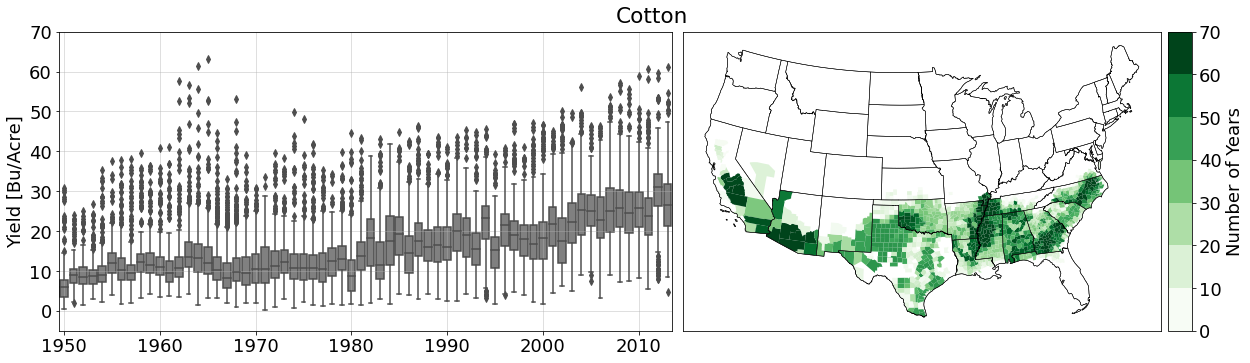

In [169]:
plot_all(cotton_all, 'Cotton')

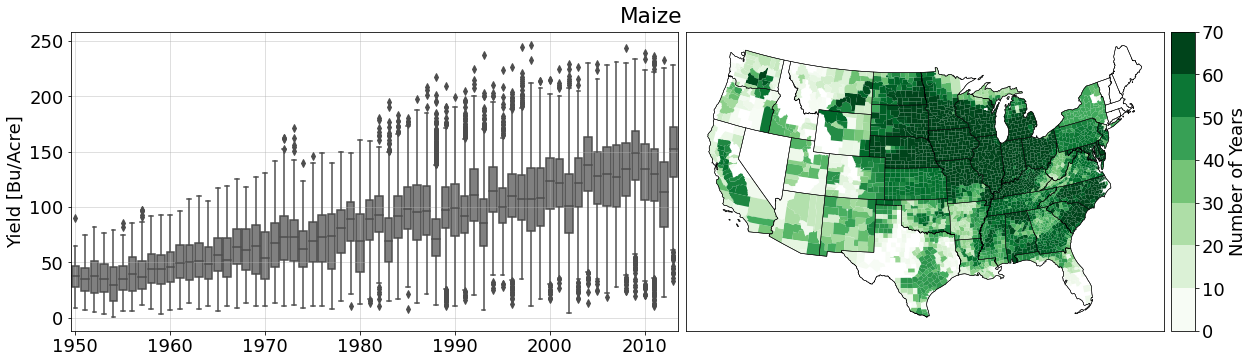

In [170]:
plot_all(maize_all, 'Maize')

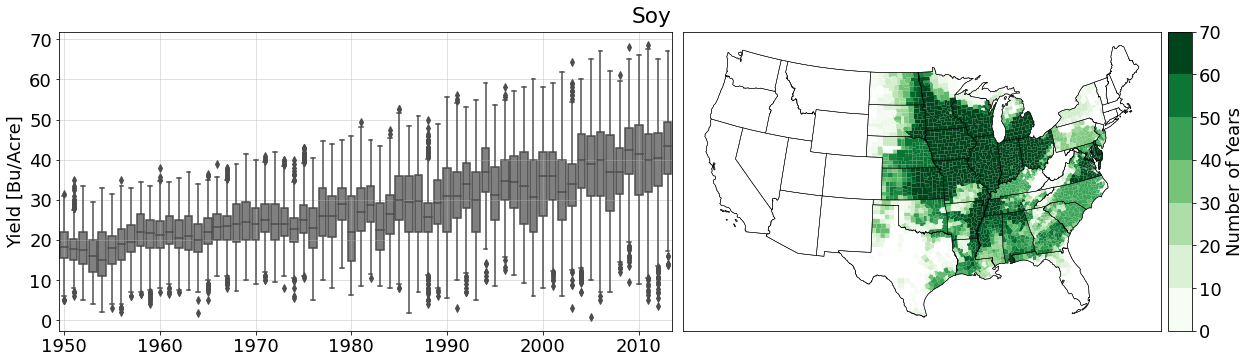

In [171]:
plot_all(soy_all, 'Soy')

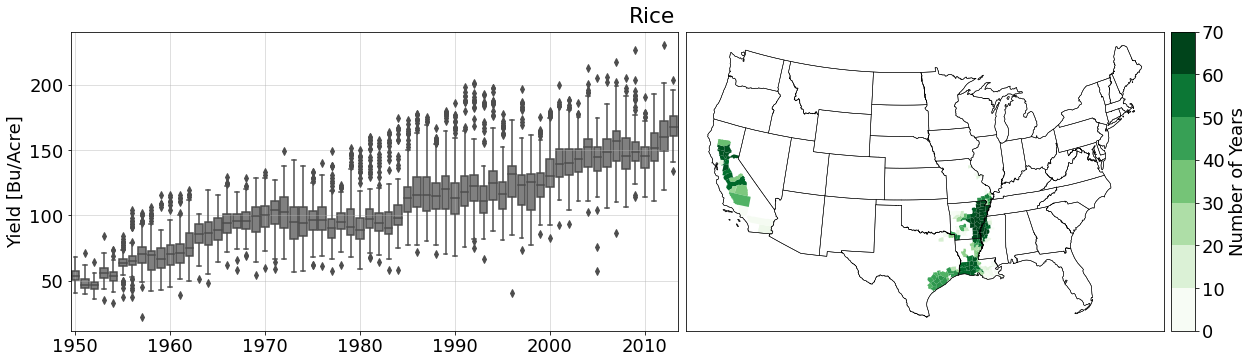

In [172]:
plot_all(rice_all, 'Rice')

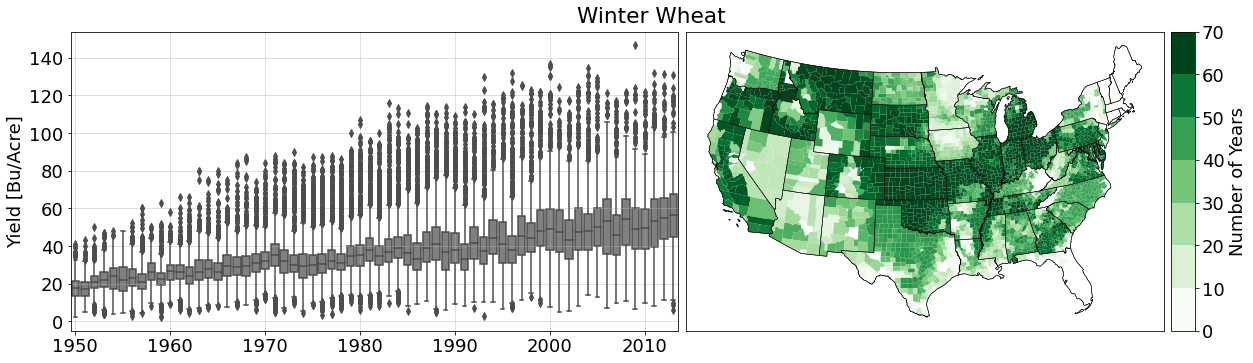

In [173]:
plot_all(winter_wheat_all, 'Winter Wheat')

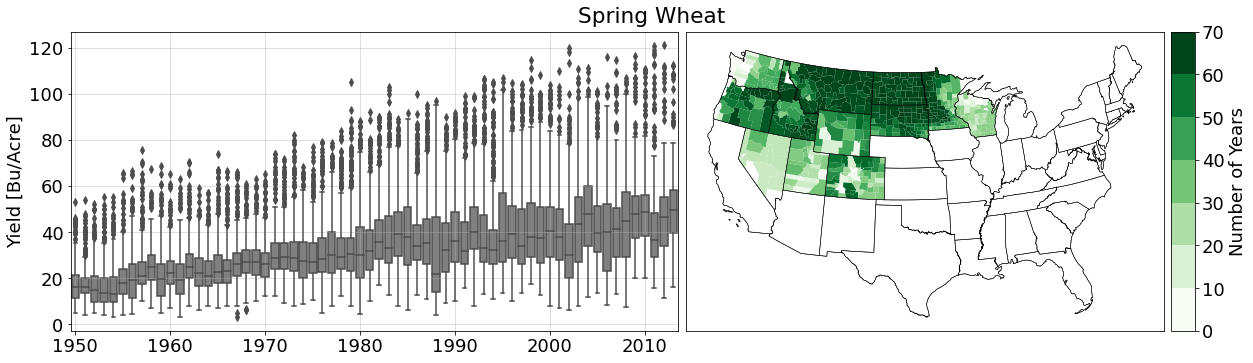

In [174]:
plot_all(spring_wheat_all, 'Spring Wheat')

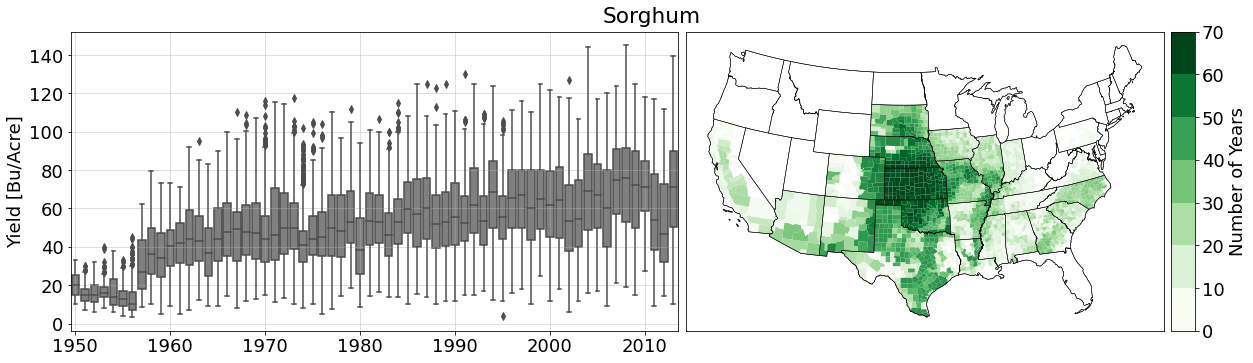

In [175]:
plot_all(sorghum_all, 'Sorghum')

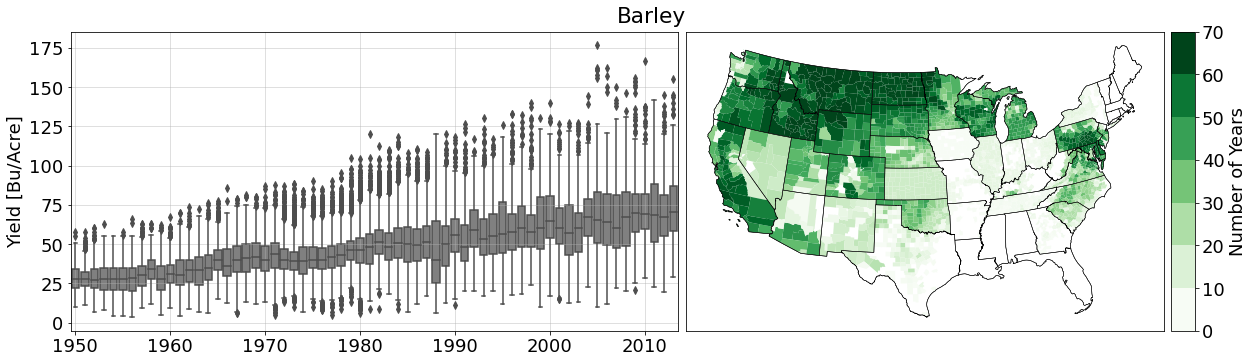

In [176]:
plot_all(barley_all, 'Barley')

In [3]:
# Find which counties for each crop are modeled (min years = 30)
maize_fips = maize_all.query('year >= 1950 and year <= 2013').groupby('fips').count().query('year >= 30').index
soy_fips = soy_all.query('year >= 1950 and year <= 2013').groupby('fips').count().query('year >= 30').index
sorghum_fips = sorghum_all.query('year >= 1950 and year <= 2013').groupby('fips').count().query('year >= 30').index
spring_wheat_fips = spring_wheat_all.query('year >= 1950 and year <= 2013').groupby('fips').count().query('year >= 30').index
cotton_fips = cotton_all.query('year >= 1950 and year <= 2013').groupby('fips').count().query('year >= 30').index
barley_fips = barley_all.query('year >= 1950 and year <= 2013').groupby('fips').count().query('year >= 30').index

In [ ]:
# # To check which crops for which counties
# fips_1 = reduce(np.intersect1d, (sorghum_fips, cotton_fips, maize_fips))
# fips_1 = [fips for fips in fips_1 if (fips[:2] == '40')]

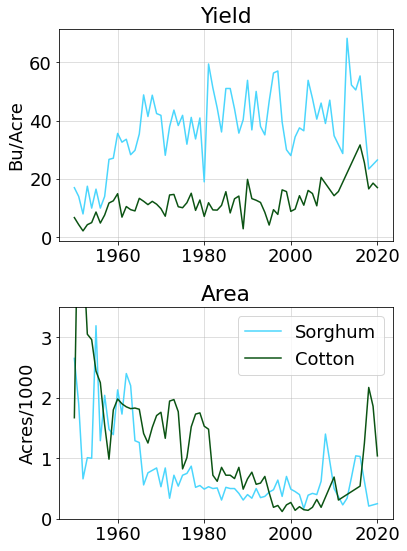

In [49]:
# First choice: southern great plans
# Custer County, OK
fips_1 = '40039'

# Plot all for single county
sorghum_plot = sorghum_all.query('fips == "' + fips_1 + '"')
cotton_plot = cotton_all.query('fips == "' + fips_1 + '"')

crops = ['maize', 'soy', 'sorghum', 'springwheat', 'barley', 'cotton']
colors = ["#a0e85b", "#104b6d", "#4bd6fd", "#3e8e9d", "#85e8b7", "#0b5313"]

fig, axs = plt.subplots(2,1, figsize=(6, 8))

# Yield
ax=axs[0]
ax.plot(sorghum_plot['year'], sorghum_plot['yield'], color=colors[2])
ax.plot(cotton_plot['year'], cotton_plot['yield'], color=colors[5])
ax.set_ylabel('Bu/Acre')
ax.set_title('Yield')
ax.grid(alpha=0.5)

# Area
ax=axs[1]
ax.plot(sorghum_plot['year'], sorghum_plot['area']/1e4, color=colors[2], label='Sorghum')
ax.plot(cotton_plot['year'], cotton_plot['area']/1e4, color=colors[5], label='Cotton')
ax.set_ylabel('Acres/1000')
ax.set_title('Area')
ax.grid(alpha=0.5)
ax.set_ylim([0.,3.5])
ax.legend()

plt.tight_layout()

plt.savefig('../figs/40039_hist.pdf')

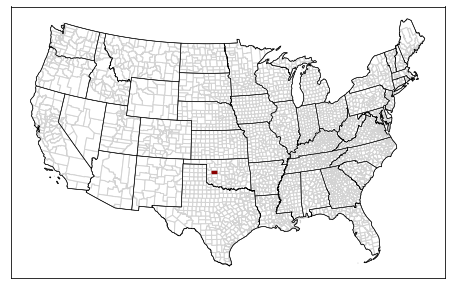

In [28]:
# Location plot
fig, ax =plt.subplots(figsize=(10,5))

county_shp_plot.plot(ax=ax, color='white', edgecolor='lightgray')
county_shp_plot.query('fips == "40039"').plot(ax=ax, color='darkred')

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)

ax.tick_params(labelbottom=False, labelleft=False, color = 'white')

plt.savefig('../figs/40039_loc.png', dpi=300)

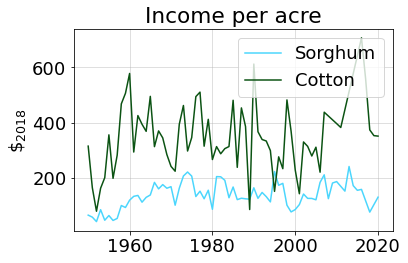

In [50]:
# Price plot
sorghum_ppi['year'] = sorghum_ppi['date'].str[:4].astype(int)
sorghum_income = pd.merge(sorghum_ppi, sorghum_plot, on='year')
sorghum_income['income'] = sorghum_income['yield'] * sorghum_income['value_ppi']

cotton_ppi['year'] = cotton_ppi['date'].str[:4].astype(int)
cotton_income = pd.merge(cotton_ppi, cotton_plot, on='year')
cotton_income['income'] = cotton_income['yield'] * cotton_income['value_ppi']

fig, ax = plt.subplots(1,1, figsize=(6, 4))

# Income
ax.plot(sorghum_income['year'], sorghum_income['income'], color=colors[2], label='Sorghum')
ax.plot(cotton_income['year'], cotton_income['income'], color=colors[5], label='Cotton')
ax.set_ylabel('$\$_{2018}$')
ax.set_title('Income per acre')
ax.grid(alpha=0.5)
ax.legend()

plt.tight_layout()

plt.savefig('../figs/40039_income_hist.pdf')

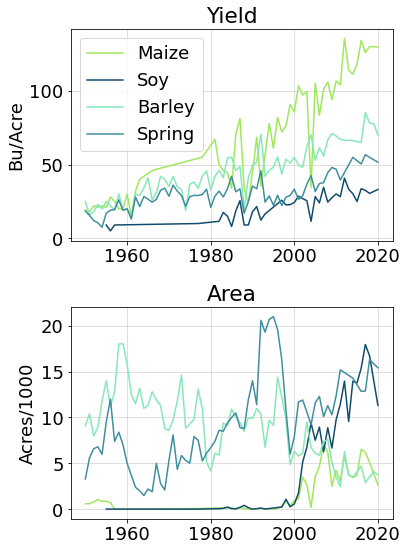

In [51]:
#  Northern Great Plans
# Ramsey County, ND
fips_2 = '38071'

# Plot all for single county
maize_plot = maize_all.query('fips == "' + fips_2 + '"')
soy_plot = soy_all.query('fips == "' + fips_2 + '"')
barley_plot = barley_all.query('fips == "' + fips_2 + '"')
spring_wheat_plot = spring_wheat_all.query('fips == "' + fips_2 + '"')

crops = ['maize', 'soy', 'sorghum', 'springwheat', 'barley', 'cotton']
colors = ["#a0e85b", "#104b6d", "#4bd6fd", "#3e8e9d", "#85e8b7", "#0b5313"]

fig, axs = plt.subplots(2,1, figsize=(6, 8))

# Yield
ax=axs[0]
ax.plot(maize_plot['year'], maize_plot['yield'], color=colors[0], label='Maize')
ax.plot(soy_plot['year'], soy_plot['yield'], color=colors[1], label='Soy')
ax.plot(barley_plot['year'], barley_plot['yield'], color=colors[4], label='Barley')
ax.plot(spring_wheat_plot['year'], spring_wheat_plot['yield'], color=colors[3], label='Spring')
ax.set_ylabel('Bu/Acre')
ax.set_title('Yield')
ax.grid(alpha=0.5)
ax.legend()

# Area
ax=axs[1]
ax.plot(maize_plot['year'], maize_plot['area']/1e4, color=colors[0])
ax.plot(soy_plot['year'], soy_plot['area']/1e4, color=colors[1])
ax.plot(barley_plot['year'], barley_plot['area']/1e4, color=colors[4], label='Barley')
ax.plot(spring_wheat_plot['year'], spring_wheat_plot['area']/1e4, color=colors[3], label='Spring')
ax.set_ylabel('Acres/1000')
ax.set_title('Area')
ax.grid(alpha=0.5)

plt.tight_layout()

plt.savefig('../figs/38071_hist.pdf')

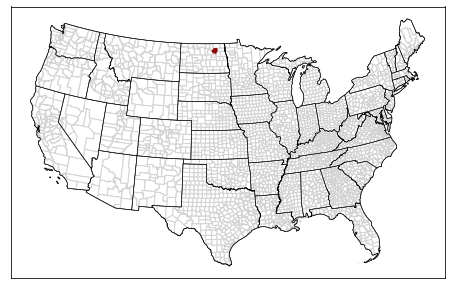

In [29]:
# Location plot
fig, ax =plt.subplots(figsize=(10,5))

county_shp_plot.plot(ax=ax, color='white', edgecolor='lightgray')
county_shp_plot.query('fips == "38071"').plot(ax=ax, color='darkred')

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)

ax.tick_params(labelbottom=False, labelleft=False, color = 'white')

plt.savefig('../figs/38071_loc.png', dpi=300)

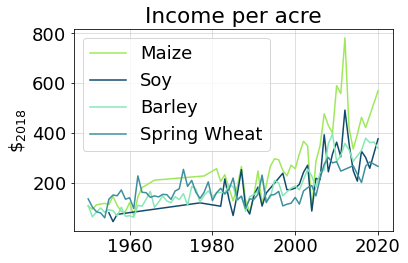

In [52]:
# Price plot
maize_ppi['year'] = maize_ppi['date'].str[:4].astype(int)
maize_income = pd.merge(maize_ppi, maize_plot, on='year')
maize_income['income'] = maize_income['yield'] * maize_income['value_ppi']

soy_ppi['year'] = soy_ppi['date'].str[:4].astype(int)
soy_income = pd.merge(soy_ppi, soy_plot, on='year')
soy_income['income'] = soy_income['yield'] * soy_income['value_ppi']

barley_ppi['year'] = barley_ppi['date'].str[:4].astype(int)
barley_income = pd.merge(barley_ppi, barley_plot, on='year')
barley_income['income'] = barley_income['yield'] * barley_income['value_ppi']

wheat_ppi['year'] = wheat_ppi['date'].str[:4].astype(int)
spring_wheat_income = pd.merge(wheat_ppi, spring_wheat_plot, on='year')
spring_wheat_income['income'] = spring_wheat_income['yield'] * spring_wheat_income['value_ppi']

fig, ax = plt.subplots(1,1, figsize=(6, 4))

# Income
ax.plot(maize_income['year'], maize_income['income'], color=colors[0], label='Maize')
ax.plot(soy_income['year'], soy_income['income'], color=colors[1], label='Soy')
ax.plot(barley_income['year'], barley_income['income'], color=colors[4], label='Barley')
ax.plot(spring_wheat_income['year'], spring_wheat_income['income'], color=colors[3], label='Spring Wheat')
ax.set_ylabel('$\$_{2018}$')
ax.set_title('Income per acre')
ax.grid(alpha=0.5)
ax.legend()

plt.tight_layout()

plt.savefig('../figs/38017_income_hist.pdf')

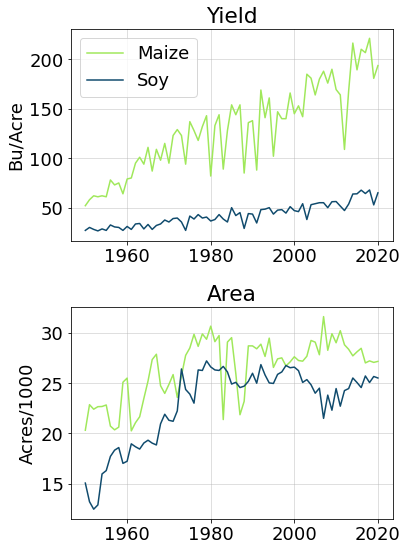

In [53]:
# Third choice: corn belt
# Champaign County, IL
fips_3 = '17019'

# Plot all for single county
maize_plot = maize_all.query('fips == "' + fips_3 + '"')
soy_plot = soy_all.query('fips == "' + fips_3 + '"')

crops = ['maize', 'soy', 'sorghum', 'springwheat', 'barley', 'cotton']
colors = ["#a0e85b", "#104b6d", "#4bd6fd", "#3e8e9d", "#85e8b7", "#0b5313"]

fig, axs = plt.subplots(2,1, figsize=(6, 8))

# Yield
ax=axs[0]
ax.plot(maize_plot['year'], maize_plot['yield'], color=colors[0], label='Maize')
ax.plot(soy_plot['year'], soy_plot['yield'], color=colors[1], label='Soy')
ax.set_ylabel('Bu/Acre')
ax.set_title('Yield')
ax.grid(alpha=0.5)
ax.legend()

# Area
ax=axs[1]
ax.plot(maize_plot['year'], maize_plot['area']/1e4, color=colors[0])
ax.plot(soy_plot['year'], soy_plot['area']/1e4, color=colors[1])
ax.set_ylabel('Acres/1000')
ax.set_title('Area')
ax.grid(alpha=0.5)

plt.tight_layout()

plt.savefig('../figs/17019_hist.pdf')

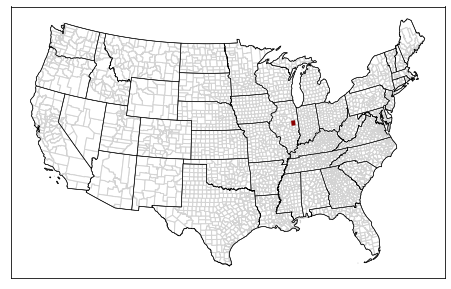

In [30]:
# Location plot
fig, ax =plt.subplots(figsize=(10,5))

county_shp_plot.plot(ax=ax, color='white', edgecolor='lightgray')
county_shp_plot.query('fips == "17019"').plot(ax=ax, color='darkred')

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)

ax.tick_params(labelbottom=False, labelleft=False, color = 'white')

plt.savefig('../figs/17019_loc.png', dpi=300)

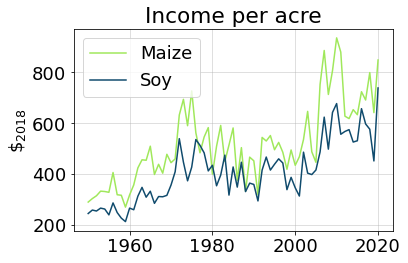

In [54]:
# Price plot
maize_ppi['year'] = maize_ppi['date'].str[:4].astype(int)
maize_income = pd.merge(maize_ppi, maize_plot, on='year')
maize_income['income'] = maize_income['yield'] * maize_income['value_ppi']

soy_ppi['year'] = soy_ppi['date'].str[:4].astype(int)
soy_income = pd.merge(soy_ppi, soy_plot, on='year')
soy_income['income'] = soy_income['yield'] * soy_income['value_ppi']

fig, ax = plt.subplots(1,1, figsize=(6, 4))

# Income
ax.plot(maize_income['year'], maize_income['income'], color=colors[0], label='Maize')
ax.plot(soy_income['year'], soy_income['income'], color=colors[1], label='Soy')
ax.set_ylabel('$\$_{2018}$')
ax.set_title('Income per acre')
ax.grid(alpha=0.5)
ax.legend()

plt.tight_layout()

plt.savefig('../figs/17019_income_hist.pdf')